In [50]:
import tensorflow as tf
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from cell_division.nets.custom_layers import (
    w_cel_loss, 
    focal_loss,
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.grad_cam import GradCAM, overlay_heatmap, CAM

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)

increase_gpu_memory()
set_gpu_allocator()

ValueError: Cannot set memory growth on device when virtual devices configured

In [2]:
img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/train.csv'
label_test_dir = v.data_path + 'CellDivision/test.csv'
label_val_dir = v.data_path + 'CellDivision/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

Dataset (Generators)

Generatos do not load directly the images into memory, but they load the images on the fly. This is useful when the dataset is too large to fit into memory.

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

Transfer Learning 

In [4]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)): 
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [5]:
base_models = {
    'DenseNet121': tf.keras.applications.DenseNet121,
    'EfficientNetV2L': tf.keras.applications.EfficientNetV2L,
    'EfficientNetV2M': tf.keras.applications.EfficientNetV2M,
    'VGG16': tf.keras.applications.VGG16,
    'ResNet50': tf.keras.applications.ResNet50,
    'InceptionV3': tf.keras.applications.InceptionV3,
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'NASNetMobile': tf.keras.applications.NASNetMobile,
}


In [6]:
param_grid = {
    'base_model': list(base_models.keys()),
    'lr': [1e-3, 1e-2],
    # 'fine_tune': [True, False],
    'loss': [focal_loss(), w_cel_loss(), extended_w_cel_loss()],
    'top': ['CAM', 'Standard'],
    # 'class_weight': [None, 'balanced']
}

In [7]:
bar = LoadingBar(
    len(param_grid['base_model']) * len(param_grid['lr']) * len(param_grid['loss']) * len(param_grid['top'])
)

results = {}

for base_model in param_grid['base_model']:
    for lr in param_grid['lr']:
        for loss in param_grid['loss']:
            for top in param_grid['top']:
                print(f'\n{c.OKGREEN}Model: {base_model} - LR: {lr} - Loss: {loss} - Top: {top}{c.ENDC}')
                
                try:
                    model = CNN(
                        base=base_models[base_model],
                        n_classes=3,
                        input_shape=INPUT_SHAPE
                    )
                    model.build_top(activation='softmax', b_type=top)
                    model.compile(lr=lr, loss=loss)
                    model.fit(
                        train_generator,
                        val_generator,
                        epochs=100,
                        batch_size=BATCH_SIZE,
                        save=False,
                        verbose=1
                    )

                    results[
                        str((base_model, lr, loss.__name__, top))
                    ] = model.model.history.history
                except Exception as e:
                    print(f'{c.FAIL}Error:{c.ENDC} {e}')
                    results[str((base_model, lr, loss.__name__, top))] = None

                clear_session()
                bar.update()
                    
    with open(f'../cell_division/results/{base_model}.json', 'w') as f:
        json.dump(results, f, cls=NumpyEncoder)
    results = {}

bar.end()


Model: DenseNet121 - LR: 0.001 - Loss: <function focal_loss.<locals>.focal_loss_fixed at 0x732900deca60> - Top: CAM
Shape after transition layer: (None, 1, 1, 1024)
Shape after pooling layer: (None, 1024)
Epoch 1/100
96/96 [==============================] - 22s 159ms/step - loss: 0.2658 - auc: 0.6844 - val_loss: 0.1032 - val_auc: 0.7168 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 11s 118ms/step - loss: 0.1980 - auc: 0.7567 - val_loss: 0.1166 - val_auc: 0.7399 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 12s 123ms/step - loss: 0.1426 - auc: 0.7955 - val_loss: 0.1809 - val_auc: 0.7783 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - ETA: 0s - loss: 0.1335 - auc: 0.8275
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
96/96 [==============================] - 11s 116ms/step - loss: 0.1335 - auc: 0.8275 - val_loss: 0.0987 - val_auc: 0.7952 - lr: 0.0010
Epoch 5/100
96/96 [==============================] 

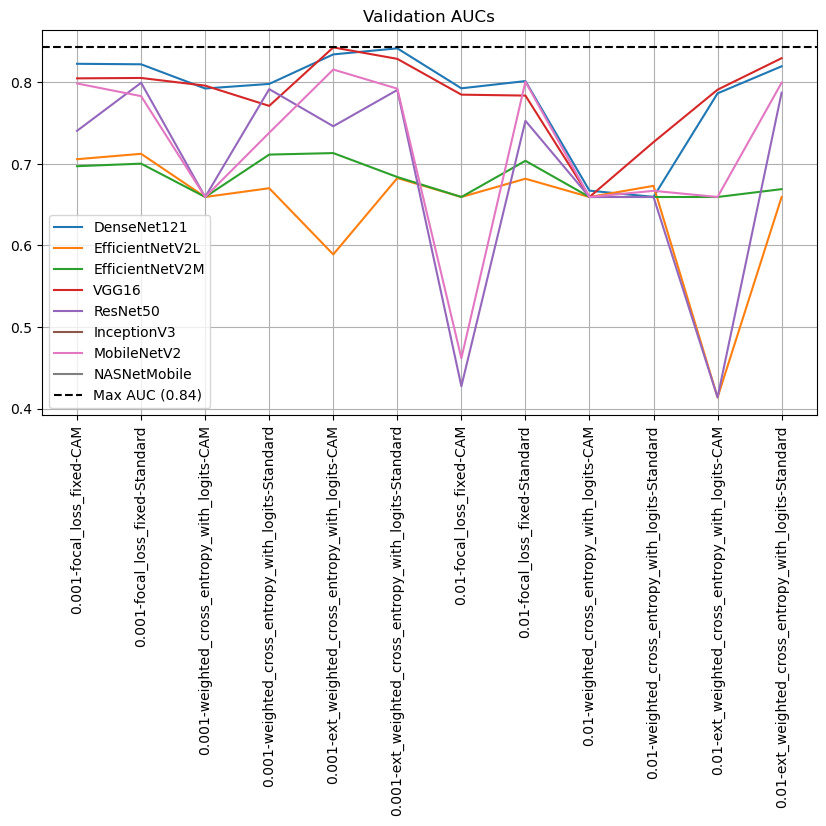

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

max_auc = 0
for base_model in param_grid['base_model']:
    try:
        with open(f'../cell_division/results/{base_model}.json', 'r') as f:
            results = json.load(f)
        
            val_aucs = [
                max(value['val_auc']) 
                for value in results.values() 
                if value is not None
            ]
            plt.plot(val_aucs, label=base_model)
            max_auc = max(max_auc, max(val_aucs))
    except:
        pass
    
plt.axhline(max_auc, color='black', linestyle='--', label=f'Max AUC ({max_auc:.2f})')

x_ticks = []
for lr in param_grid['lr']:
    for loss in param_grid['loss']:
        for top in param_grid['top']:
            x_ticks.append(f'{lr}-{loss.__name__}-{top}')
            
plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
    
plt.title('Validation AUCs')
plt.legend()
plt.grid()
plt.show()

Epoch 1/100
24/24 [==============================] - 39s 2s/step - loss: 3.6988 - auc: 0.6627 - val_loss: 1.3250 - val_auc: 0.8001 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 19s 791ms/step - loss: 2.1320 - auc: 0.8208 - val_loss: 1.2839 - val_auc: 0.8077 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 19s 799ms/step - loss: 1.4693 - auc: 0.8705 - val_loss: 1.3026 - val_auc: 0.7985 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 19s 779ms/step - loss: 1.2817 - auc: 0.8902 - val_loss: 1.1763 - val_auc: 0.8293 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 19s 799ms/step - loss: 1.0960 - auc: 0.9082 - val_loss: 1.1539 - val_auc: 0.8119 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - ETA: 0s - loss: 1.1044 - auc: 0.9137
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
24/24 [==============================] - 19s 817ms/step - loss: 1.1044 - auc: 0.9137 - val_loss: 1.08

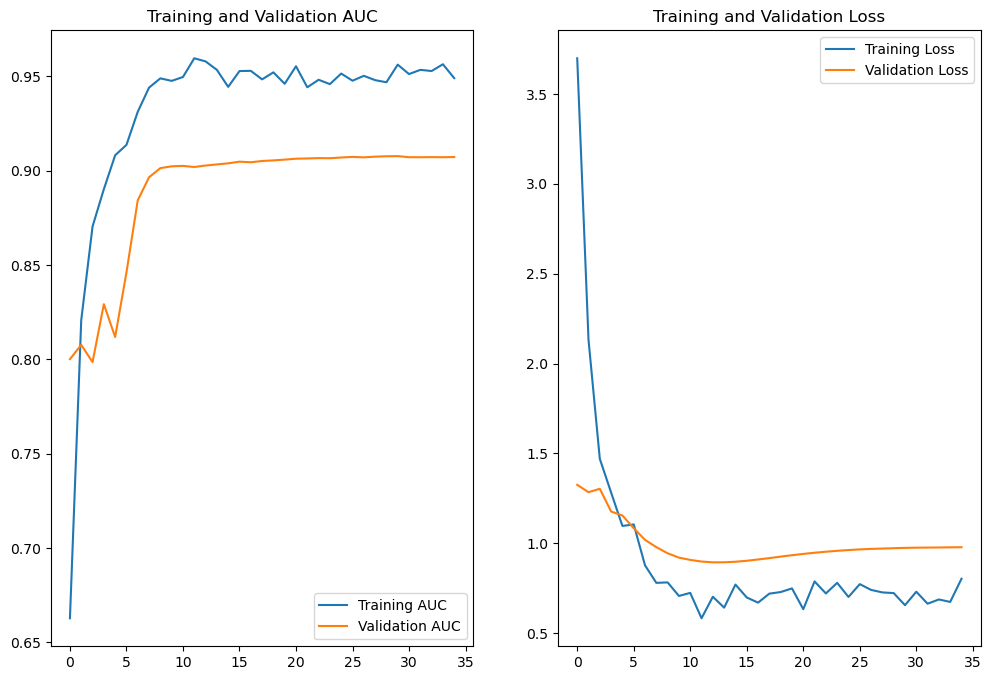

In [7]:
model = CNN(
    base=base_models['VGG16'],
    n_classes=3,
    input_shape=INPUT_SHAPE
)
model.build_top(activation='softmax', b_type='CAM')
model.compile(lr=.001, loss=extended_w_cel_loss())
model.fit(
    train_generator,
    val_generator,
    epochs=100,
    batch_size=BATCH_SIZE,
    save=True,
    verbose=2
)

Class activation mapping

In [7]:
# model = CNN(
#     base=base_models['VGG16'],
#     n_classes=3,
#     input_shape=INPUT_SHAPE
# )
# model.build_top(activation='softmax', b_type='CAM')
# model.compile(lr=.001, loss=extended_w_cel_loss())
# model.model.load_weights('../models/cellular_division_models/vgg16_simple.h5')

In [65]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

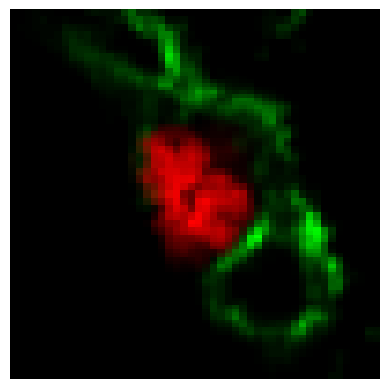

In [75]:
img_idx = 98
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


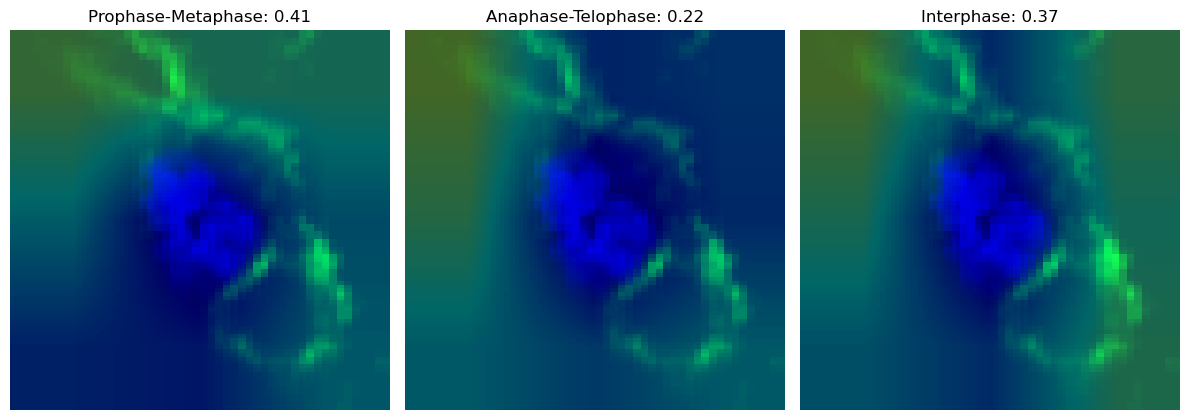

In [76]:
cam = GradCAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.6)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.6)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.6)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


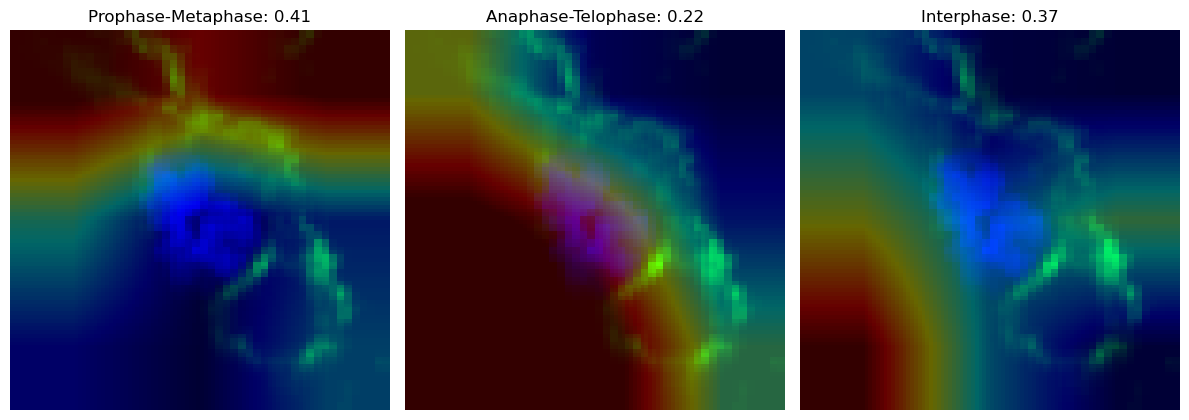

In [77]:
cam = CAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0, normalize=True)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1, normalize=True)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2, normalize=True)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.6)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.6)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.6)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

Test AUC

In [69]:
results = model.model.evaluate(test_generator, verbose=1)

165/165 [==============================] - 9s 52ms/step - loss: 0.5260 - auc: 0.8307


In [70]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.67      0.92      0.78       101
Anaphase/Telophase       0.00      0.00      0.00        35
        Interphase       0.59      0.55      0.57        29

          accuracy                           0.66       165
         macro avg       0.42      0.49      0.45       165
      weighted avg       0.52      0.66      0.58       165



<Figure size 1200x1200 with 0 Axes>

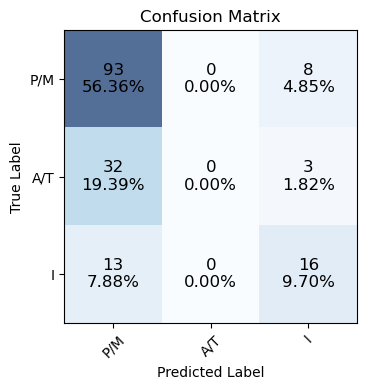

In [71]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

Class distribution in all sets

In [72]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

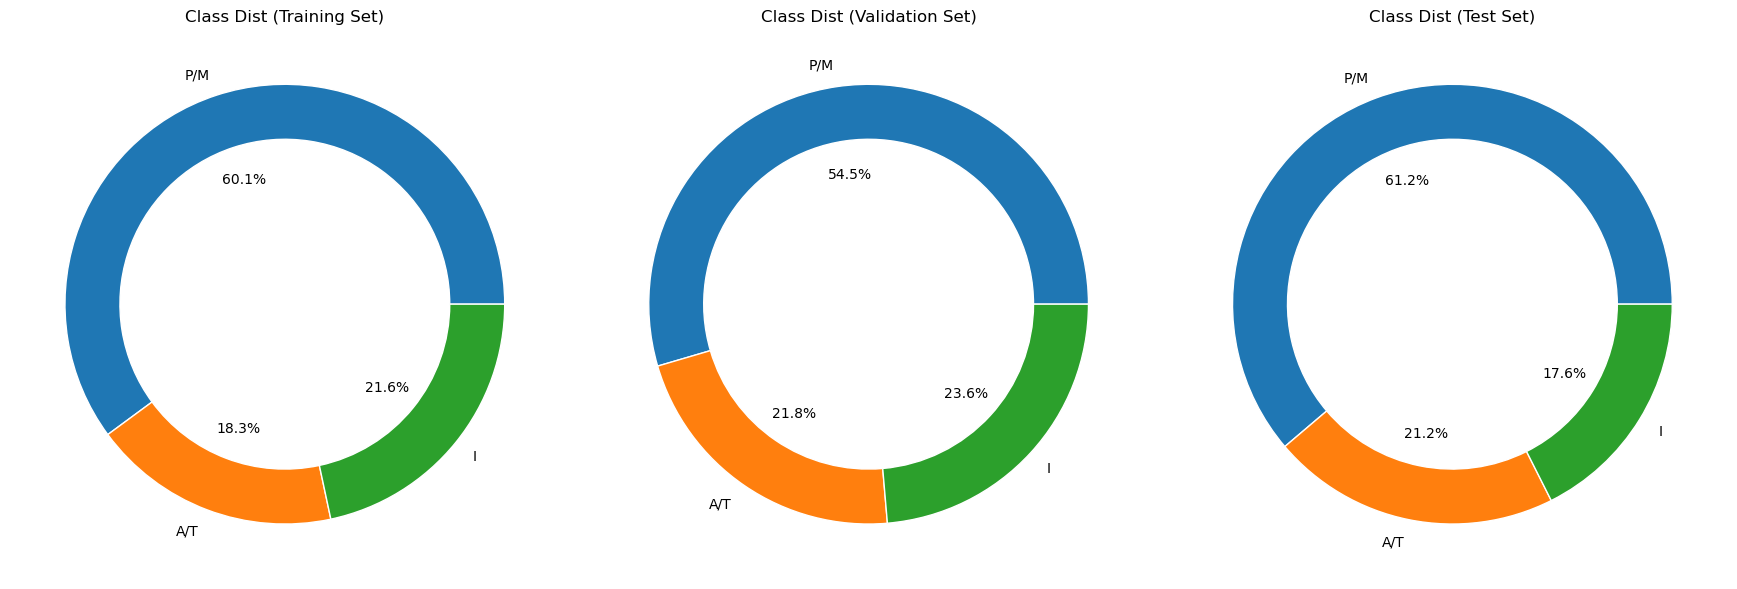

In [73]:
plt.figure(figsize=(18, 6))

for i, dataset in enumerate([
    train_generator.img_labels, 
    val_generator.img_labels,
    test_generator.img_labels
]):
    plt.subplot(1, 3, i + 1)
    plt.pie(
        np.bincount(dataset.astype(int)), 
        labels=['P/M', 'A/T', 'I'],
        colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
        autopct='%.1f%%',
        wedgeprops=dict(width=.25, edgecolor='w')
    )
    
    plt.title('Class Dist' + (' (Training Set)' if i == 0 else ' (Test Set)' if i == 2 else ' (Validation Set)'))
    plt.tight_layout()
	
plt.show()
